In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import skimage.morphology as morph
from matplotlib_scalebar.scalebar import ScaleBar

from src.Segmentation3D import get_voxel_size_35mm
from src.HolomonitorFunctions import get_pixel_size
from src.FormatConversions import import_tomocube_stack, import_holomonitor_stack

In [3]:
vox_to_um = get_voxel_size_35mm()
pix_to_um = get_pixel_size()

In [4]:
# folder = '../../data/Tomocube/MDCK_10.02.2025/A2P1'
# filename = '250210.113448.MDCK dynamics.001.MDCK B.A2'

# n_im, h_im = import_tomocube_stack(folder, filename, h_scaling=vox_to_um[0], f_min=2, f_max=3)
# n_im[n_im == 0] = np.nan

# df = pd.read_csv(f"{folder}/area_volume_filtered.csv")
# edges = np.load(f"{folder}/cell_edges.npy")[9]

# Import Holomonitor
file = "A1-18"
dir  = "../../data/Holomonitor/MDCK_19.03.2024/"

fmin = 132
h_im = import_holomonitor_stack(dir, file, f_min=fmin, f_max=fmin+1)
areas = np.load(f"{dir}{file}/cell_areas.npy")[2]

df_holo = pd.read_csv(f"{dir}{file}/area_volume_unfiltered.csv")
df = df_holo[df_holo.frame == 2]


In [5]:
cellwise_heigts = np.copy(areas)

for l in np.unique(areas):
    mask = (areas == l)
    df_mask = df.label==l

    if np.sum(df_mask) == 0:
        continue
    
    cellwise_heigts[mask] = df[df_mask].h_avrg.values[0]

In [6]:
cells_with_edges   = np.zeros_like(cellwise_heigts, dtype=np.float64)
heights_with_edges = np.zeros_like(cellwise_heigts)
edges = np.zeros_like(cellwise_heigts)

for l in np.unique(areas):
    cell = (areas == l)
    cell_interior = morph.erosion(cell, footprint=morph.disk(2))
    edge = cell ^ cell_interior

    cells_with_edges   += cell_interior*h_im[0]
    heights_with_edges += cell_interior*cellwise_heigts
    edges += edge

In [7]:
colors = [(1, 1, 1, 0),    # Color for 0 (transparent)
          (0.698, 0.132, 0.203, 0.5)]  # Color for 1 (semi-transparent red)
    
# Create a colormap from the defined colors
e_cmap = mpl.colors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=2)

h_cmap = "gray"

/tmp/ipykernel_16624/719721465.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  ax[1].plot(df[df.frame==2].x, df[df.frame==2].y, 'r.', ms=2, alpha=1, color="red")


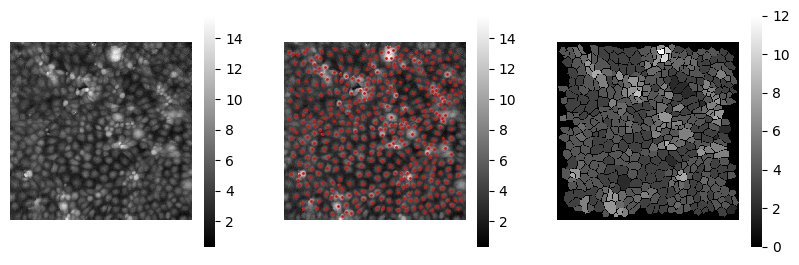

In [8]:
fig, ax = plt.subplots(1,3, figsize=(10, 3), gridspec_kw={"width_ratios":[1, 1, 1]})

sns.heatmap(h_im[0].T,            ax=ax[0], square=True, cmap=h_cmap, xticklabels=False, yticklabels=False, cbar=True)
sns.heatmap(h_im[0].T,            ax=ax[1], square=True, cmap=h_cmap, xticklabels=False, yticklabels=False, cbar=True)
sns.heatmap(heights_with_edges.T, ax=ax[2], square=True, cmap=h_cmap, xticklabels=False, yticklabels=False, cbar=True)
#sns.heatmap(edges.T,              ax=ax[1], square=True, cmap=e_cmap, xticklabels=False, yticklabels=False, cbar=False)

ax[1].plot(df[df.frame==2].x, df[df.frame==2].y, 'r.', ms=2, alpha=1, color="red")

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()

In [9]:
for i in range(3):
    sb = ScaleBar(pix_to_um[-1], 'um', box_alpha=0, color="w", height_fraction=2e-2, scale_loc="none", fixed_value=100)
    sb.location = 'lower left'
    ax[i].add_artist(sb)

ax[0].set(title=r"$h_{2D}$ (µm)")
ax[1].set(title=r"$h_{2D}$ (µm)")
ax[2].set(title=r"$\bar{h}_{2D, cell}$ (µm)")
#ax[2].set(title=r"$\langle h \rangle_{cell}$ (µm)")

[Text(0.5, 1.0, '$\\bar{h}_{2D, cell}$ (µm)')]

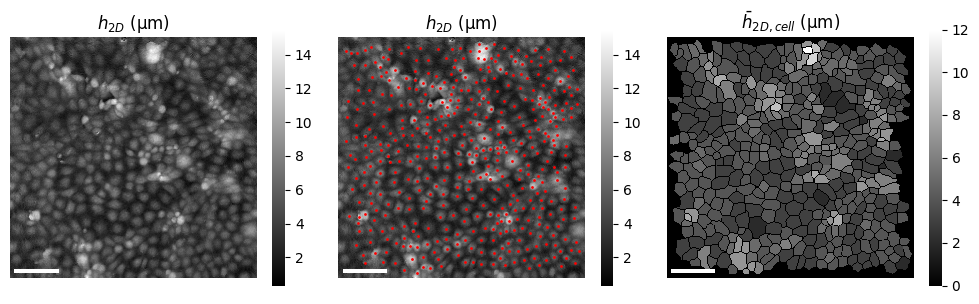

In [10]:
fig.tight_layout()
fig.savefig(f"../../figs/illustrations/cell_area_illustration_centers.png", dpi=300)
fig